To start with, I have taken ideas from the following code esp. to see how GCN works. Although, it does not use any CNN. 

Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 

In [1]:
# import libraries

import os
import pandas as pd

In [2]:
# Import Libraries for Graph, GNN, and GCN

import stellargraph as sg
from stellargraph import StellarGraph

from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

In [3]:
# Machine Learnig related library Imports

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
drop_rows_with_na = 1

In [5]:
df = pd.DataFrame();
data_file = "small-stock-price--all-merged.csv"
# stock-price--all-merged.csv"
df = pd.read_csv("./data/" + data_file);
df.head()

,Unnamed: 0,Ticker,Date,Low,Open,Volume,High,Close,Adjusted Close
0,0,WY,03-05-1973,18.458332,18.833332,116700,19.333332,19.083332,1.415370
1,1,WY,04-05-1973,19.583332,19.583332,256800,19.958332,19.666668,1.458635
2,2,WY,07-05-1973,19.541668,19.666668,55800,19.708332,19.583332,1.452454
3,3,WY,08-05-1973,19.416668,19.583332,80100,19.583332,19.583332,1.452454
4,4,WY,09-05-1973,19.541668,19.583332,66900,19.791668,19.666668,1.458635


In [6]:
df_s =  df[ ['Ticker', 'Date', 'Adjusted Close'] ];
df_s

,Ticker,Date,Adjusted Close
0,WY,03-05-1973,1.415370
1,WY,04-05-1973,1.458635
2,WY,07-05-1973,1.452454
3,WY,08-05-1973,1.452454
4,WY,09-05-1973,1.458635
...,...,...,...
74640,ZTS,06-12-2022,153.050003
74641,ZTS,07-12-2022,150.250000
74642,ZTS,08-12-2022,153.679993
74643,ZTS,09-12-2022,153.389999


In [7]:
df_s.shape

(74645, 3)

In [8]:
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s

C:\Users\sayed\AppData\Local\Temp\ipykernel_39420\690785714.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_s["Date"] = df_s["Date"].astype('datetime64[ns]')
C:\Users\sayed\AppData\Local\Temp\ipykernel_39420\690785714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["Date"] = df_s["Date"].astype('datetime64[ns]')


,Ticker,Date,Adjusted Close
33545,XOM,1970-01-04,0.157565
33567,XOM,1970-01-05,0.147974
33588,XOM,1970-01-06,0.158475
33610,XOM,1970-01-07,0.152206
33653,XOM,1970-01-09,0.184500
...,...,...,...
30145,XEL,2022-12-12,70.500000
17581,WYNN,2022-12-12,85.919998
12513,WY,2022-12-12,31.844999
49649,XYL,2022-12-12,111.231003


In [9]:
# DataFrame.pivot_table
df_s_pivot = df_s.pivot_table(index = 'Ticker', columns = 'Date', values = 'Adjusted Close')
df_s_pivot

Date,1970-01-04,1970-01-05,1970-01-06,1970-01-07,1970-01-09,1970-01-10,1970-01-12,1970-01-13,1970-01-14,1970-01-15,...,2022-11-29,2022-11-30,2022-12-01,2022-12-04,2022-12-05,2022-12-07,2022-12-08,2022-12-09,2022-12-10,2022-12-12
Ticker,,,,,,,,,,,,,,,,,,,,,
WY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.585228,32.529999,38.842178,38.972717,37.633583,34.238174,36.493679,34.369823,29.228270,31.844999
WYNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.290001,83.660004,85.800003,71.500000,58.560001,54.730000,68.739998,64.510002,58.709999,85.919998
XEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.849998,70.220001,67.188744,73.714508,72.550545,69.048271,75.466278,76.906860,57.939999,70.500000
XLEFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.175400,0.165000,0.197200,0.230350,0.186830,0.192300,0.179370,0.178000,0.165000,NaN
XOM,0.157565,0.147974,0.158475,0.152206,0.1845,0.188388,0.205969,0.170238,0.170581,0.168868,...,110.540001,111.339996,68.425552,83.246559,84.787003,83.018562,93.249321,96.830490,97.643944,105.330002
XYL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,109.879997,112.349998,114.688019,84.037300,81.997032,76.324005,102.766029,97.340027,86.987679,111.231003
YUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,126.040001,128.660004,126.714371,118.175095,108.929268,114.738968,117.047028,116.725037,105.058510,128.320007
ZBH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.000000,120.099998,121.143295,126.072327,112.593025,102.800041,116.958374,119.003792,107.059998,125.190002
ZION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.029999,51.820000,68.328407,61.841976,52.314281,49.448040,57.347908,58.146046,48.048351,47.709999


In [10]:
df_s_pivot = df_s.pivot(index = 'Ticker', columns = 'Date', values = 'Adjusted Close')
df_s_pivot

Date,1970-01-04,1970-01-05,1970-01-06,1970-01-07,1970-01-09,1970-01-10,1970-01-12,1970-01-13,1970-01-14,1970-01-15,...,2022-11-29,2022-11-30,2022-12-01,2022-12-04,2022-12-05,2022-12-07,2022-12-08,2022-12-09,2022-12-10,2022-12-12
Ticker,,,,,,,,,,,,,,,,,,,,,
WY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.585228,32.529999,38.842178,38.972717,37.633583,34.238174,36.493679,34.369823,29.228270,31.844999
WYNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.290001,83.660004,85.800003,71.500000,58.560001,54.730000,68.739998,64.510002,58.709999,85.919998
XEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.849998,70.220001,67.188744,73.714508,72.550545,69.048271,75.466278,76.906860,57.939999,70.500000
XLEFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.175400,0.165000,0.197200,0.230350,0.186830,0.192300,0.179370,0.178000,0.165000,NaN
XOM,0.157565,0.147974,0.158475,0.152206,0.1845,0.188388,0.205969,0.170238,0.170581,0.168868,...,110.540001,111.339996,68.425552,83.246559,84.787003,83.018562,93.249321,96.830490,97.643944,105.330002
XYL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,109.879997,112.349998,114.688019,84.037300,81.997032,76.324005,102.766029,97.340027,86.987679,111.231003
YUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,126.040001,128.660004,126.714371,118.175095,108.929268,114.738968,117.047028,116.725037,105.058510,128.320007
ZBH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.000000,120.099998,121.143295,126.072327,112.593025,102.800041,116.958374,119.003792,107.059998,125.190002
ZION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.029999,51.820000,68.328407,61.841976,52.314281,49.448040,57.347908,58.146046,48.048351,47.709999


In [11]:
# df_s_pivot.corr()

In [12]:
df_s_transpose = df_s_pivot.T
df_s_transpose

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,
1970-01-04,NaN,NaN,NaN,NaN,0.157565,NaN,NaN,NaN,NaN,NaN
1970-01-05,NaN,NaN,NaN,NaN,0.147974,NaN,NaN,NaN,NaN,NaN
1970-01-06,NaN,NaN,NaN,NaN,0.158475,NaN,NaN,NaN,NaN,NaN
1970-01-07,NaN,NaN,NaN,NaN,0.152206,NaN,NaN,NaN,NaN,NaN
1970-01-09,NaN,NaN,NaN,NaN,0.184500,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-07,34.238174,54.730000,69.048271,0.19230,83.018562,76.324005,114.738968,102.800041,49.448040,173.123749
2022-12-08,36.493679,68.739998,75.466278,0.17937,93.249321,102.766029,117.047028,116.958374,57.347908,175.297516
2022-12-09,34.369823,64.510002,76.906860,0.17800,96.830490,97.340027,116.725037,119.003792,58.146046,165.997284


In [13]:
if drop_rows_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis=0);
    #df_s_transpose["Date"] = df_s_transpose["Date"].astype('datetime64[ns]')
    #df_s_transpose.sort_values(by='Date', ascending=False)
    df_s_transpose.to_csv('./data/ticker-columns-small-stock-price-all-merged.csv');
   
df_s_transpose.head(100)

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,
2013-01-02,20.883371,103.048119,20.478704,0.0585,58.954189,24.504324,39.336575,65.839821,20.096922,28.952980
2013-01-03,20.438263,95.828918,20.990484,0.0585,58.928879,24.147791,38.907013,67.201973,20.197556,32.304829
2013-01-04,21.654745,101.271027,21.830513,0.0960,59.811855,23.936962,42.462990,67.512596,20.819284,30.428169
2013-01-05,20.832233,111.982628,23.203228,0.0870,57.663715,24.156570,40.536289,67.665359,20.315172,31.237307
2013-01-07,19.546804,106.370384,20.907310,0.0870,59.913769,24.386118,42.107372,67.576027,24.694487,28.636538
...,...,...,...,...,...,...,...,...,...,...
2013-06-13,19.901571,113.044418,21.609106,0.0870,60.597176,24.050970,42.940895,70.487000,23.163177,29.160431
2013-06-14,19.678972,111.901726,21.712433,0.0870,60.099556,23.918682,42.641071,69.965797,22.683588,28.814285
2013-06-17,19.936348,114.592873,21.756708,0.0870,60.716595,24.050970,42.934887,71.574310,22.767727,28.963976


In [14]:
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')

# Note: the above data has null and missing values. That will be addressed.

In [15]:
# Experiment find correlations
# Ref: https://towardsdatascience.com/time-series-and-correlations-with-stock-market-data-using-python-e66774e3a16f

In [16]:
# df_s_transpose = df_s_transpose.fillna(0);

# Pearson Correlation Coefficient

In [17]:
df_s_transpose_pearson = df_s_transpose.corr()
df_s_transpose_pearson

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Ticker,,,,,,,,,,
WY,1.000000,-0.096668,0.649323,0.572186,0.372683,0.725986,0.714593,0.595592,0.840381,0.718518
WYNN,-0.096668,1.000000,-0.386965,0.002870,0.005917,-0.192025,-0.267199,-0.109233,-0.071168,-0.348395
XEL,0.649323,-0.386965,1.000000,0.634048,0.021992,0.907268,0.946322,0.781452,0.773665,0.948077
XLEFF,0.572186,0.002870,0.634048,1.000000,0.072248,0.695186,0.695990,0.488452,0.688164,0.675154
XOM,0.372683,0.005917,0.021992,0.072248,1.000000,0.030656,0.133538,-0.188314,0.307871,-0.010085
XYL,0.725986,-0.192025,0.907268,0.695186,0.030656,1.000000,0.955698,0.810726,0.865556,0.941812
YUM,0.714593,-0.267199,0.946322,0.695990,0.133538,0.955698,1.000000,0.764817,0.878860,0.954247
ZBH,0.595592,-0.109233,0.781452,0.488452,-0.188314,0.810726,0.764817,1.000000,0.631353,0.756662
ZION,0.840381,-0.071168,0.773665,0.688164,0.307871,0.865556,0.878860,0.631353,1.000000,0.813806


# Pearson Correlation Coefficient based Adjacency Graph Matrix

In [18]:
df_s_transpose_pearson[df_s_transpose_pearson >= 0.5] = 1
df_s_transpose_pearson[df_s_transpose_pearson < 0.5] = 0
df_s_transpose_pearson

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Ticker,,,,,,,,,,
WY,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
WYNN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XEL,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
XLEFF,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
XOM,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
XYL,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
YUM,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ZBH,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
ZION,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


# Spearman Correlation Coefficient 

In [19]:
df_s_transpose_spearman = df_s_transpose.corr(method='spearman')
df_s_transpose_spearman

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Ticker,,,,,,,,,,
WY,1.000000,-0.024507,0.656217,0.446881,0.197225,0.721356,0.677714,0.646461,0.764333,0.688669
WYNN,-0.024507,1.000000,-0.361188,0.055383,0.172181,-0.179372,-0.249199,-0.109099,-0.014040,-0.335967
XEL,0.656217,-0.361188,1.000000,0.592792,-0.119004,0.940604,0.948714,0.815851,0.794496,0.969704
XLEFF,0.446881,0.055383,0.592792,1.000000,-0.022676,0.642227,0.645913,0.438980,0.648388,0.629287
XOM,0.197225,0.172181,-0.119004,-0.022676,1.000000,-0.071883,-0.053836,-0.207490,0.125050,-0.170009
XYL,0.721356,-0.179372,0.940604,0.642227,-0.071883,1.000000,0.962513,0.844919,0.874153,0.954748
YUM,0.677714,-0.249199,0.948714,0.645913,-0.053836,0.962513,1.000000,0.823905,0.881926,0.963845
ZBH,0.646461,-0.109099,0.815851,0.438980,-0.207490,0.844919,0.823905,1.000000,0.675687,0.837512
ZION,0.764333,-0.014040,0.794496,0.648388,0.125050,0.874153,0.881926,0.675687,1.000000,0.835269


# Spearman Correlation Coefficient based Adjacency Graph Matrix

In [20]:
df_s_transpose_spearman[df_s_transpose_spearman >= 0.4] = 1
df_s_transpose_spearman[df_s_transpose_spearman < 0.4] = 0
df_s_transpose_spearman

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Ticker,,,,,,,,,,
WY,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
WYNN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XEL,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
XLEFF,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
XOM,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
XYL,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
YUM,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ZBH,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ZION,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


# Find Kendall Correlation Coefficient

In [21]:
df_s_transpose_kendall = df_s_transpose.corr(method='kendall')
df_s_transpose_kendall

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Ticker,,,,,,,,,,
WY,1.000000,-0.008544,0.496151,0.287353,0.135625,0.540468,0.517248,0.464727,0.583282,0.533627
WYNN,-0.008544,1.000000,-0.253453,0.033290,0.142122,-0.108556,-0.152433,-0.059714,0.021557,-0.219898
XEL,0.496151,-0.253453,1.000000,0.382282,-0.096051,0.771179,0.795176,0.623614,0.563132,0.840853
XLEFF,0.287353,0.033290,0.382282,1.000000,-0.016651,0.414277,0.429430,0.299577,0.455170,0.403436
XOM,0.135625,0.142122,-0.096051,-0.016651,1.000000,-0.029698,-0.033426,-0.114000,0.089203,-0.124349
XYL,0.540468,-0.108556,0.771179,0.414277,-0.029698,1.000000,0.829498,0.655981,0.670453,0.812713
YUM,0.517248,-0.152433,0.795176,0.429430,-0.033426,0.829498,1.000000,0.630930,0.682253,0.841465
ZBH,0.464727,-0.059714,0.623614,0.299577,-0.114000,0.655981,0.630930,1.000000,0.472226,0.640518
ZION,0.583282,0.021557,0.563132,0.455170,0.089203,0.670453,0.682253,0.472226,1.000000,0.621643


# Kendall Correlation Coefficient based Adjacency Graph Matrix

In [22]:
df_s_transpose_kendall[df_s_transpose_kendall >= 0.3 ] = 1
df_s_transpose_kendall[df_s_transpose_kendall < 0.3 ] = 0
df_s_transpose_kendall

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Ticker,,,,,,,,,,
WY,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
WYNN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XEL,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
XLEFF,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
XOM,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
XYL,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
YUM,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ZBH,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
ZION,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


Create and visualize the Graphs

In [23]:
import networkx as nx
Graph_pearson = nx.Graph(df_s_transpose_pearson)

In [24]:
Graph_spearman = nx.Graph(df_s_transpose_spearman)
Graph_kendall = nx.Graph(df_s_transpose_kendall)

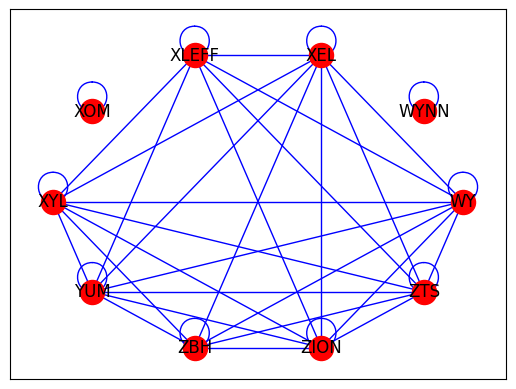

In [25]:
nx.draw_networkx(Graph_pearson, pos=nx.circular_layout(Graph_pearson), node_color='r', edge_color='b')

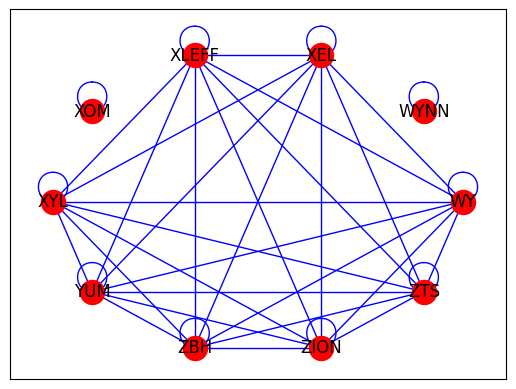

In [26]:
nx.draw_networkx(Graph_spearman, pos=nx.circular_layout(Graph_spearman), node_color='r', edge_color='b')

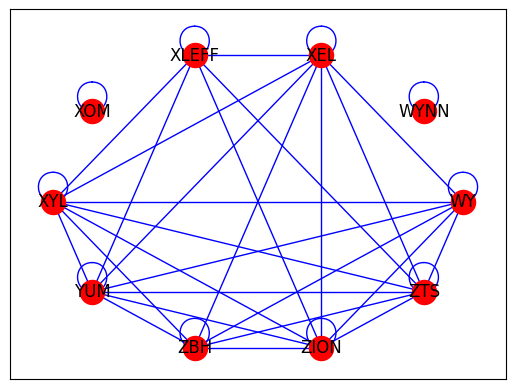

In [27]:
nx.draw_networkx(Graph_kendall, pos=nx.circular_layout(Graph_kendall), node_color='r', edge_color='b')

# Create GCN layer. Pearson

# Find all stocks = nodes

In [28]:
# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_pearson.index.to_list()
all_stock_nodes

['WY', 'WYNN', 'XEL', 'XLEFF', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']

# Find all edges between nodes

In [29]:
source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_pearson[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)
            
source, target, edge_feature            

(['WY',
  'WY',
  'WY',
  'WY',
  'WY',
  'WY',
  'WY',
  'WY',
  'WYNN',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XOM',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS'],
 ['WY',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  'WYNN',
  'WY',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  'WY',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZION',
  'ZTS',
  'XOM',
  'WY',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  'WY',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  'WY',
  'XEL',
  'XYL',
  

In [30]:
# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
pearson_edges = pd.DataFrame(
    {"source": source, "target": target}
)

pearson_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


pearson_edges[:10]

,source,target
0,WY,WY
1,WY,XEL
2,WY,XLEFF
3,WY,XYL
4,WY,YUM
5,WY,ZBH
6,WY,ZION
7,WY,ZTS
8,WYNN,WYNN
9,XEL,WY


In [31]:
# Graph with No Feature Data, No node data, only edges

pearson_graph = StellarGraph(edges = pearson_edges, node_type_default="corner", edge_type_default="line")
#pearson_graph = StellarGraph(nodes = all_stock_nodes, edges = pearson_edges)
# graph = sg.StellarGraph(all_stock_nodes, square_edges)
print(pearson_graph.info())

In [32]:
# Trying to have the time series data as part of the nodes

In [33]:
df_s_transpose

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,
2013-01-02,20.883371,103.048119,20.478704,0.05850,58.954189,24.504324,39.336575,65.839821,20.096922,28.952980
2013-01-03,20.438263,95.828918,20.990484,0.05850,58.928879,24.147791,38.907013,67.201973,20.197556,32.304829
2013-01-04,21.654745,101.271027,21.830513,0.09600,59.811855,23.936962,42.462990,67.512596,20.819284,30.428169
2013-01-05,20.832233,111.982628,23.203228,0.08700,57.663715,24.156570,40.536289,67.665359,20.315172,31.237307
2013-01-07,19.546804,106.370384,20.907310,0.08700,59.913769,24.386118,42.107372,67.576027,24.694487,28.636538
...,...,...,...,...,...,...,...,...,...,...
2022-12-05,37.633583,58.560001,72.550545,0.18683,84.787003,81.997032,108.929268,112.593025,52.314281,162.436111
2022-12-07,34.238174,54.730000,69.048271,0.19230,83.018562,76.324005,114.738968,102.800041,49.448040,173.123749
2022-12-08,36.493679,68.739998,75.466278,0.17937,93.249321,102.766029,117.047028,116.958374,57.347908,175.297516


# Structure the Feature Matrix so that it can be passed to the GCN

In [34]:
df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace=False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
df_s_transpose_feature['WY'].values

array([20.88337135, 20.43826294, 21.6547451 , ..., 36.49367905,
       34.36982346, 29.22826958])

In [35]:
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    

[array([20.88337135, 20.43826294, 21.6547451 , ..., 36.49367905,
        34.36982346, 29.22826958]),
 array([103.04811859,  95.82891846, 101.27102661, ...,  68.73999786,
         64.51000214,  58.70999908]),
 array([20.47870445, 20.99048424, 21.830513  , ..., 75.46627808,
        76.90686035, 57.93999863]),
 array([0.0585    , 0.0585    , 0.096     , ..., 0.17937   , 0.178     ,
        0.16500001]),
 array([58.9541893 , 58.92887878, 59.81185532, ..., 93.24932098,
        96.83049011, 97.64394379]),
 array([ 24.50432396,  24.14779091,  23.93696213, ..., 102.76602936,
         97.34002686,  86.98767853]),
 array([ 39.33657455,  38.90701294,  42.46298981, ..., 117.04702759,
        116.72503662, 105.05850983]),
 array([ 65.83982086,  67.20197296,  67.51259613, ..., 116.95837402,
        119.00379181, 107.05999756]),
 array([20.09692192, 20.19755554, 20.81928444, ..., 57.34790802,
        58.14604568, 48.04835129]),
 array([ 28.95298004,  32.30482864,  30.42816925, ..., 175.29751587,
    

In [54]:
pearson_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)

pearson_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
WY,20.883371,20.438263,21.654745,20.832233,19.546804,19.692883,20.427731,21.428579,21.841364,20.908264,...,31.038254,31.585228,32.529999,38.842178,38.972717,37.633583,34.238174,36.493679,34.369823,29.228270
WYNN,103.048119,95.828918,101.271027,111.982628,106.370384,113.806229,133.505219,139.868958,101.328606,112.311447,...,78.199997,80.290001,83.660004,85.800003,71.500000,58.560001,54.730000,68.739998,64.510002,58.709999
XEL,20.478704,20.990484,21.830513,23.203228,20.907310,22.606117,20.919912,21.770561,21.882168,23.136805,...,69.389999,68.849998,70.220001,67.188744,73.714508,72.550545,69.048271,75.466278,76.906860,57.939999
XLEFF,0.058500,0.058500,0.096000,0.087000,0.087000,0.087000,0.087000,0.087000,0.096000,0.087000,...,0.175400,0.175400,0.165000,0.197200,0.230350,0.186830,0.192300,0.179370,0.178000,0.165000
XOM,58.954189,58.928879,59.811855,57.663715,59.913769,61.526085,57.455147,60.007206,59.686665,58.401745,...,109.809998,110.540001,111.339996,68.425552,83.246559,84.787003,83.018562,93.249321,96.830490,97.643944
XYL,24.504324,24.147791,23.936962,24.156570,24.386118,22.216503,25.022806,29.558672,23.910618,24.103863,...,109.610001,109.879997,112.349998,114.688019,84.037300,81.997032,76.324005,102.766029,97.340027,86.987679
YUM,39.336575,38.907013,42.462990,40.536289,42.107372,44.518383,43.120792,41.467388,41.854408,40.824135,...,126.449997,126.040001,128.660004,126.714371,118.175095,108.929268,114.738968,117.047028,116.725037,105.058510
ZBH,65.839821,67.201973,67.512596,67.665359,67.576027,76.108650,74.430153,79.379471,67.692314,68.006851,...,117.669998,119.000000,120.099998,121.143295,126.072327,112.593025,102.800041,116.958374,119.003792,107.059998
ZION,20.096922,20.197556,20.819284,20.315172,24.694487,25.367598,23.557787,23.945360,20.567228,20.710051,...,50.230000,51.029999,51.820000,68.328407,61.841976,52.314281,49.448040,57.347908,58.146046,48.048351
ZTS,28.952980,32.304829,30.428169,31.237307,28.636538,28.276628,29.795467,29.912426,30.390823,31.134403,...,148.130005,147.850006,154.139999,211.260025,186.840927,162.436111,173.123749,175.297516,165.997284,145.550735


# Graph with feature as part of Nodes

In [37]:
pearson_graph_with_node_features = StellarGraph(pearson_graph_node_data, edges = pearson_edges, node_type_default="corner", edge_type_default="line")
print(pearson_graph_with_node_features.info())


StellarGraph: Undirected multigraph
 Nodes: 10, Edges: 64

 Node types:
  corner: [10]
    Features: float32 vector, length 2483
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [64]
        Weights: all 1 (default)
        Features: none


In [38]:
# Generator
generator = FullBatchNodeGenerator(pearson_graph_with_node_features, method = "gcn")

Using GCN (local pooling) filters...


No need for this block

Graph with feature as part of both Nodes and edges
although Edge data is not required


pearson_graph_with_edge_features = StellarGraph(pearson_graph_node_data, edges = pearson_edges, node_type_default="corner", edge_type_default="line")
print(pearson_graph_with_edge_features.info())
generator = FullBatchNodeGenerator(pearson_graph_with_edge_features, method = "gcn")

In [39]:
# Train Test Split

In [40]:
train_subjects, test_subjects = model_selection.train_test_split(
    pearson_graph_node_data #, train_size = 6, test_size = 4
)
# , train_size=6, test_size=None, stratify=pearson_graph_node_data

val_subjects, test_subjects_ = model_selection.train_test_split(
    test_subjects #, test_size = 2
)

#, train_size=500, test_size=None, stratify=test_subjects

#val_subjects, test_subjects = model_selection.train_test_split(
#    test_subjects, train_size=500, test_size=None, stratify=test_subjects
#)

train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_.shape

((7, 2483), (3, 2483), (2, 2483), (1, 2483))

In [41]:
pearson_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
WY,20.883371,20.438263,21.654745,20.832233,19.546804,19.692883,20.427731,21.428579,21.841364,20.908264,...,31.038254,31.585228,32.529999,38.842178,38.972717,37.633583,34.238174,36.493679,34.369823,29.228270
WYNN,103.048119,95.828918,101.271027,111.982628,106.370384,113.806229,133.505219,139.868958,101.328606,112.311447,...,78.199997,80.290001,83.660004,85.800003,71.500000,58.560001,54.730000,68.739998,64.510002,58.709999
XEL,20.478704,20.990484,21.830513,23.203228,20.907310,22.606117,20.919912,21.770561,21.882168,23.136805,...,69.389999,68.849998,70.220001,67.188744,73.714508,72.550545,69.048271,75.466278,76.906860,57.939999
XLEFF,0.058500,0.058500,0.096000,0.087000,0.087000,0.087000,0.087000,0.087000,0.096000,0.087000,...,0.175400,0.175400,0.165000,0.197200,0.230350,0.186830,0.192300,0.179370,0.178000,0.165000
XOM,58.954189,58.928879,59.811855,57.663715,59.913769,61.526085,57.455147,60.007206,59.686665,58.401745,...,109.809998,110.540001,111.339996,68.425552,83.246559,84.787003,83.018562,93.249321,96.830490,97.643944
XYL,24.504324,24.147791,23.936962,24.156570,24.386118,22.216503,25.022806,29.558672,23.910618,24.103863,...,109.610001,109.879997,112.349998,114.688019,84.037300,81.997032,76.324005,102.766029,97.340027,86.987679
YUM,39.336575,38.907013,42.462990,40.536289,42.107372,44.518383,43.120792,41.467388,41.854408,40.824135,...,126.449997,126.040001,128.660004,126.714371,118.175095,108.929268,114.738968,117.047028,116.725037,105.058510
ZBH,65.839821,67.201973,67.512596,67.665359,67.576027,76.108650,74.430153,79.379471,67.692314,68.006851,...,117.669998,119.000000,120.099998,121.143295,126.072327,112.593025,102.800041,116.958374,119.003792,107.059998
ZION,20.096922,20.197556,20.819284,20.315172,24.694487,25.367598,23.557787,23.945360,20.567228,20.710051,...,50.230000,51.029999,51.820000,68.328407,61.841976,52.314281,49.448040,57.347908,58.146046,48.048351
ZTS,28.952980,32.304829,30.428169,31.237307,28.636538,28.276628,29.795467,29.912426,30.390823,31.134403,...,148.130005,147.850006,154.139999,211.260025,186.840927,162.436111,173.123749,175.297516,165.997284,145.550735


In [42]:
train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 

In [43]:
train_gen = generator.flow(train_subjects.index, train_targets)

# This was there, but for classification, model does not match. I am changing
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator , dropout=0.5
)
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)


In [44]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

# layer_sizes = [32, 1, 32, 1, 32, 1]
# activations = ["relu", 'linear', "relu", 'linear',"relu", 'linear']

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()

#x_out = Conv1D(filters = 2, kernel_size = 2)(x_out)
#x_out = MaxPool1D(pool_size=2)(x_out)
#x_out = Conv1D(filters = 32, kernel_size = sum(layer_sizes))(x_out)
#prediction = keras.layers.Reshape((-1,))(prediction)
#x_out = keras.layers.Reshape((1,16))(x_out)
#x_out = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator)(x_out) #, dropout = 0.5

# predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
x_out, 
x_inp, x_out

([<KerasTensor: shape=(1, 10, 2483) dtype=float32 (created by layer 'input_1')>,
  <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
  <KerasTensor: shape=(1, None, 2) dtype=int64 (created by layer 'input_3')>,
  <KerasTensor: shape=(1, None) dtype=float32 (created by layer 'input_4')>],
 <KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'gather_indices')>)

# Experiment with Models

In [45]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

# layer_sizes = [32, 1, 32, 1, 32, 1]
# activations = ["relu", 'linear', "relu", 'linear',"relu", 'linear']

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()
xout = x_out

#x_out = Conv1D(filters = 7, kernel_size = 7)(x_out)
input_shape = (4, 10, 128)
x_out = Conv1D(32, 3, activation = 'relu', input_shape = x_out[1:] )(x_out)
#x_out = MaxPool1D(pool_size=2)(x_out)
#x_out = Conv1D(filters = 32, kernel_size = sum(layer_sizes))(x_out)
#prediction = keras.layers.Reshape((-1,))(prediction)
#x_out = keras.layers.Reshape((1,16))(x_out)

# Generator
#generator2 = FullBatchNodeGenerator(x_out, method = "gcn")
gcn2 = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator)#(x_out) #, dropout = 0.5

# predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
#x_out, 
x_inp, x_out, type(xout),  vars(gcn), 
x_out[1:]

<KerasTensor: shape=(0, None, 32) dtype=float32 (created by layer 'tf.__operators__.getitem_1')>

In [46]:
import tensorflow as tf
input_shape = (4, 10, 128)
x = tf.random.normal(input_shape)
y = keras.layers.Conv1D(32, 3, activation='relu',input_shape=input_shape[1:])(x)
#print(y.shape)

#https://keras.io/api/layers/convolution_layers/convolution1d
x_out_cnn = Conv1D(32, 3, activation='relu',input_shape=input_shape[1:])(x_out)
x, 
input_shape[1:], x_out_cnn

((10, 128),
 <KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'conv1d_2')>)

In [47]:
# Not my code
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.863434]]


x_out, vars(gcn)

In [48]:
# Models

In [49]:
# loss functions: https://keras.io/api/losses/

model = Model(inputs=x_inp, outputs=predictions)
'''
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss=losses.MeanSquaredError(),
    metrics=["acc"],
)
'''
model.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.1), metrics=['mean_squared_error'])

In [50]:
len(x_inp) , predictions.shape, print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(1, 10, 2483)]      0           []                               
                                                                                                  
 input_7 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout_2 (Dropout)            (1, 10, 2483)        0           ['input_5[0][0]']                
                                                                                              

(4, TensorShape([1, None, 2483]), None)

In [51]:
len(val_subjects)
test_subjects_ = test_subjects[:len(val_subjects)]

In [52]:
# hard coded size adjustments
test_subjects_ = test_subjects[:len(val_subjects)]

val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]

train_gen[:1][:4]

In [53]:
# https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor = "val_mean_squared_error", patience = 50, restore_best_weights = True)

data_valid = val_gen #[:1][:4];
train_gen_data = train_gen #[:1][:4];

history = model.fit( train_gen_data, epochs = 100, validation_data = data_valid, verbose = 2,    
    # shuffling = true means shuffling the whole graph
    shuffle = False, callbacks = [es_callback],
)
sg.utils.plot_history(history)

# [1]

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_absolute_error/sub/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sayed\AppData\Local\Temp\ipykernel_39420\643702322.py", line 9, in <module>
      history = model.fit( train_gen_data, epochs = 100, validation_data = data_valid, verbose = 2,
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\sayed\.conda\envs\stellargraph\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/mean_absolute_error/sub/BroadcastGradientArgs'
Incompatible shapes: [1,5,2483] vs. [1,7,2483]
	 [[{{node gradient_tape/mean_absolute_error/sub/BroadcastGradientArgs}}]] [Op:__inference_train_function_12178]

In [ ]:
val_subjects, 
test_subjects

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    

# Show the predicted prices by the Model

At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
I am just displaying the output. 
It appears that price is predicted for each timestamp (day)

In [ ]:
all_nodes = pearson_graph_node_data.index;
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

all_predictions, all_predictions.shape, pearson_graph_node_data.shape

In [ ]:
vars(all_gen)

In [ ]:
# train_gen[:1][:4]

References:



[1] Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 


[2] Loading data into StellarGraph from Pandas. https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

[3] Load Timeseries https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-numpy.html

[4] NetworkX: https://networkx.org/documentation/stable/reference/introduction.html 

[5]  StellerGraph and Networkx https://stellargraph.readthedocs.io/en/latest/demos/basics/loading-networkx.html 

[6] Select StellerGraph Algorithm : https://stellargraph.readthedocs.io/en/stable/demos/#find-a-demo-for-an-algorithm 
[link text](https://)


Learning: 
GNN/GCN/Keras
https://www.youtube.com/watch?v=0KH95BEz370


Install StellarGraph:
https://pypi.org/project/stellargraph/#install-stellargraph-using-pypi


May want to use without Stellar
https://keras.io/examples/graph/gnn_citations/

to get feature data from pandas dataframe: 
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html


Create graph properly:
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html    

https://stellargraph.readthedocs.io/en/v0.11.0/api.html


Graph Regression Dataset
https://paperswithcode.com/task/graph-regression/codeless

StellerGraph Reference:
https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html
https://stellargraph.readthedocs.io

GRaph CNN or similar
It has multiple GCN layers and one 1d CNN + ... this idea might help
https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn

# References -- exploring ideas on the GCN-CNN
https://ieeexplore.ieee.org/document/9149910

https://antonsruberts.github.io/graph/gcn/

This may work. As Unit GCN is created also unit tcn. This may give the opportunity to customize to product the correct output
https://github.com/lshiwjx/2s-AGCN  https://paperswithcode.com/paper/non-local-graph-convolutional-networks-for

    

In [ ]:
import scipy.stats as stats
c, p = stats.pearsonr(df_s_transpose['WY'], df_s_transpose['WYNN'])
print(f"WY vs WYNN Pearson Correlation: {c}\n")